In [1]:
import numpy as np
from scipy.sparse import lil_array, issparse
from scipy.sparse.linalg import spsolve
from scipy.linalg import solve
import scipy.stats as st
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


RANDOM_STATE = 42


In [2]:
def get_connection_matrix(
    m, n,
    self_weight=4.0,
    other_weight=-1.0,
    directions=((0,1), (0, -1), (1, 0), (-1, 0)),
):
    conmat = lil_array((m*n, m*n), dtype=np.float64)
    conmat.setdiag(self_weight)
    for i in range(m):
        for j in range(n):
            for a, b in directions:
                k, l = i+a, j+b
                if 0 <= k < m and 0 <= l < n:
                    x = i*n + j
                    y = k*n + l
                    conmat[x, y] = other_weight
    return conmat.tocsr()
                
                
def external_heat_func(x, y, mu, sigma, seed=None):
    assert np.shape(x) == np.shape(y)
    shape = np.shape(x)
    rng = np.random.default_rng(seed)
    r = rng.normal(mu, sigma, shape)
    val = 100 * np.exp(
        -((x - 0.55)**2 + (y - 0.45)**2) / r
    )
    return val


def get_temperatures(minval, maxval, step, mu=0.05, sigma=0.005, seed=None):
    xvals = yvals = np.arange(minval+step, maxval, step)  # h, 2h, ... 1-h
    x_mesh, y_mesh = np.meshgrid(xvals, yvals)
    z = external_heat_func(x_mesh, y_mesh, mu, sigma, seed=seed)
    return z.flatten(order='C')


def solve_system(conmat, temps, pca=None):
    # temps need to be column vectors
    if pca is not None:
        sigma, vs = pca
        conmat = (vs.T / sigma) @ conmat @ vs
        temps = vs.T @ (temps.T / sigma).T
    
    if issparse(conmat):
        solution = spsolve(conmat, temps)
    else:
        solution = solve(conmat, temps)
    
    if pca is not None:
        sigma, vs = pca
        solution = vs @ solution
    
    solution = solution.T
    
    assert solution.shape[-1] == 39*39
    solution = solution.reshape(-1, 39, 39)
    solution = np.pad(solution, ((0, 0), (1, 1), (1, 1)))
    
    if solution.shape[0] == 1:
        solution = np.squeeze(solution, 0)
        
    return solution


def monte_carlo(n_samples, conmat, pca=None, seed=None):
    seeds = range(seed, seed+n_samples) if seed is not None else [None]*n_samples
    
    temps = []
    for i in range(n_samples):
        t = get_temperatures(0, 1, 1/40, seed=seeds[i])
        temps.append(t)
    temps = np.array(temps)
    
    solutions = solve_system(conmat, temps.T, pca=pca)
    return solutions


Text(0.5, 1.0, 'Exact Solution')

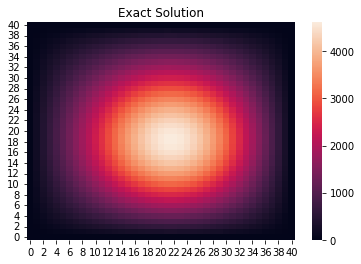

In [3]:
# FIND A SOLUTION OF AN INSTANCE AND DISPLAY IT
conmat = get_connection_matrix(39, 39)
ts = get_temperatures(0, 1, 1/40, seed=RANDOM_STATE)
solution = solve_system(conmat, ts)
ax = sns.heatmap(solution, cmap='rocket')
ax.invert_yaxis()
ax.set_title('Exact Solution')
# plt.savefig('heatmap.png', facecolor='white', transparent=False)

# # Compare sparse vs dense times
# import timeit
# dense_conmat = conmat.todense()
# sparse_time = timeit.timeit(lambda: spsolve(conmat, temps), number=100)
# dense_time = timeit.timeit(lambda: solve(dense_conmat, temps), number=100)
# print(f'Sparse Time: {sparse_time}\nDense Time: {dense_time}')
# # 0.27s
# # 8.93s


In [4]:
# MONTE CARLO (EXACT)
# assert n_samples > 39*39 = 1521
samples = monte_carlo(100_000, conmat, seed=RANDOM_STATE)
c1 = (samples.shape[-2] + 1) // 2
c2 = (samples.shape[-1] + 1) // 2
center_samples = samples[:, c1, c2]


In [5]:
# MONTE CARLO (PCA)
samples_flat = samples[:, 1:-1, 1:-1]
samples_flat = samples_flat.reshape(samples.shape[0], -1)

pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=0.99)),
    # ('pca', PCA()),
])
pipe.fit(samples_flat)


Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA(n_components=0.99))])

In [6]:
sigma = pipe['scaler'].scale_
vs = pipe['pca'].components_.T

samples_alt = monte_carlo(100_000, conmat, pca=(sigma, vs), seed=RANDOM_STATE)
center_samples_alt = samples_alt[:, c1, c2]

Number of components: 77
Explained variance ratio:  99.01%
Normality Test for the Exact Monte Carlo: NormaltestResult(statistic=4.448091633410243, pvalue=0.10817058397190449)
Normality Test for the PCA Monte Carlo: NormaltestResult(statistic=5.718994151121193, pvalue=0.05729756936841291)


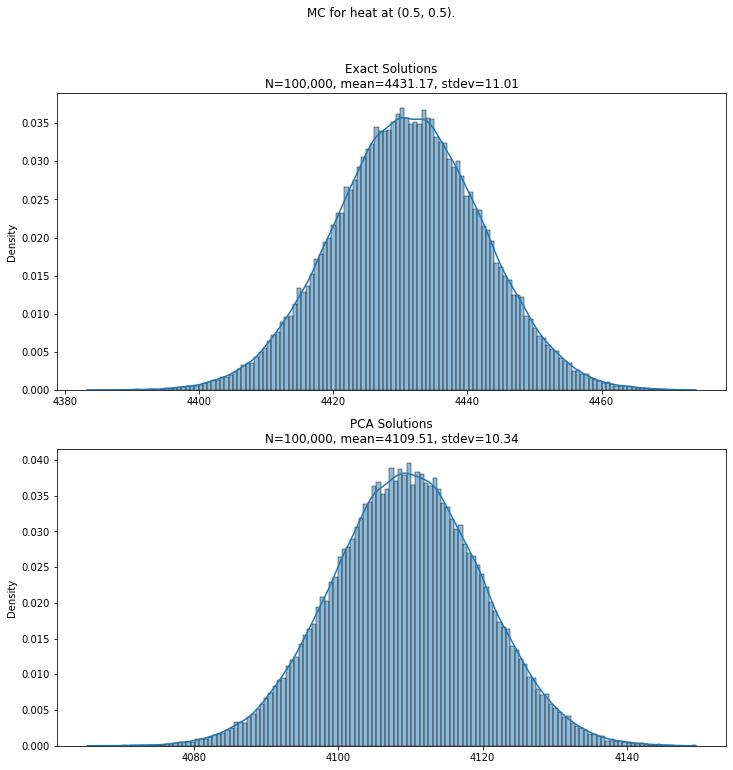

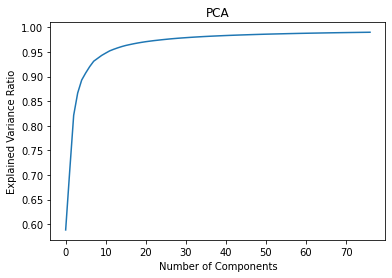

In [7]:
# DISPLAY RESULTS
fig, axs = plt.subplots(nrows=2, figsize=(12, 12))
sns.histplot(center_samples, kde=True, stat='density', ax=axs[0])
sns.histplot(center_samples_alt, kde=True, stat='density', ax=axs[1])

axs[0].set_title(
    'Exact Solutions\n'
    f'N={len(center_samples):,}, mean={center_samples.mean():.2f}, stdev={center_samples.std():.2f}'
)
axs[1].set_title(
    'PCA Solutions\n'
    f'N={len(center_samples_alt):,}, mean={center_samples_alt.mean():.2f}, stdev={center_samples_alt.std():.2f}'
)
fig.suptitle('MC for heat at (0.5, 0.5).')
# plt.savefig('dists.png', facecolor='white', transparent=False)

plt.figure()
plt.plot(np.cumsum(pipe['pca'].explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance Ratio')
plt.title('PCA')
# plt.savefig('explainedvar.png', facecolor='white', transparent=False)

print(f"Number of components: {pipe['pca'].n_components_}")
print(f"Explained variance ratio: {pipe['pca'].explained_variance_ratio_.sum(): .2%}")

# H0: "The data are normally distributed".
# The p-value is very large and thus H0 is not rejected. 
print(f'Normality Test for the Exact Monte Carlo: {st.normaltest(center_samples)}')
print(f'Normality Test for the PCA Monte Carlo: {st.normaltest(center_samples_alt)}')
